In [ ]:
from __future__ import annotations
from abc import ABC, abstractmethod
from collections.abc import Iterator
from typing import Callable
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import math
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler


# Task 1: Data Preprocessing

## 1.1: IMDB Reviews

In [ ]:
# Define a helper function to calculate the z-score
def calculate_z_score(x: np.array, y: np.array) -> float:
  """
  Calculates that z score for the given input and target vectors
  Note that this function assumes that the input and target vectors are standardized
  :param x: The input vector
  :param y: The target vector
  :return: The z-score
  """
  return np.dot(x, y) / math.sqrt(len(x))

In [ ]:
# Download and extract the full dataset
!wget -c https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvf  "aclImdb_v1.tar.gz"

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [ ]:
# Import the training and testing datasets
(imdb_train_X, imdb_train_y) = load_svmlight_file("aclImdb/train/labeledBow.feat", dtype="uint8")
(imdb_test_X, imdb_test_y) = load_svmlight_file("aclImdb/test/labeledBow.feat", dtype="uint8")

# Convert the training and testing labels to be binary
to_binary = lambda x: 1 if x >= 5 else 0
imdb_train_y = np.array(list(map(to_binary, imdb_train_y)))
imdb_test_y = np.array(list(map(to_binary, imdb_test_y)))

(num_rows, num_columns) = imdb_train_X.shape

# Count how many reviews each word appears in
tallies = np.zeros(num_columns)
for review in range(num_rows):
  for word in imdb_train_X[review].indices:
    tallies[word] += 1

# Determine which words should be kept in the dataset (in >=1% and <=50% of reviews), and which should be removed
to_keep = []
to_remove = []
for index in range(len(tallies)):
  if tallies[index] >= 0.01 * num_rows and tallies[index] <= 0.50 * num_rows:
    to_keep.append(index)
  else:
    to_remove.append(index)

imdb_train_X = imdb_train_X.toarray()
imdb_test_X = imdb_test_X.toarray()

# Remove the words that should not be kept in the dataset
imdb_train_X_reduced = np.delete(imdb_train_X, to_remove, 1)

# Standardize the reduced training data
imdb_train_X_standardized = StandardScaler().fit_transform(imdb_train_X_reduced)
imdb_train_y_standardized = StandardScaler().fit_transform(np.reshape(imdb_train_y, (-1, 1)))

# Calculate the z-score for each feature
z_scores = []
for feature in imdb_train_X_standardized.T:
  z_scores.append(calculate_z_score(feature, np.reshape(imdb_train_y_standardized, (num_rows))))

# Calculate the absolute z-scores for each feature and associate it with its feature index
absolute_z_scores = []
for i in range(len(z_scores)):
  absolute_z_scores.append([abs(z_scores[i]), to_keep[i]])

# Sort by absolute z-score
absolute_z_scores.sort()
absolute_z_scores.reverse()

# Identify the words that were selected and the ones that weren't
num_scores = 250 # Chosen based on analysis of the 1000 words with the highest z-scores
selected = []
for i in range(num_scores):
  selected.append(absolute_z_scores[i][1])
not_selected = []
for i in range(num_columns):
  if i not in selected:
    not_selected.append(i)

# Reduce the training and testing datasets to include only the selected features
imdb_train_X_final = StandardScaler().fit_transform(np.delete(imdb_train_X, not_selected, 1))
imdb_train_y_final = imdb_train_y
imdb_test_X_final = StandardScaler().fit_transform(np.delete(imdb_test_X, not_selected[:89273], 1))
imdb_test_y_final = imdb_test_y

## 1.2: 20 News Groups

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse


In [ ]:
#Read in the train dataset for chosen 4 categories.
cats = ['comp.sys.ibm.pc.hardware', 'sci.space', 'rec.sport.hockey', 'talk.politics.mideast']


#0: hardware, 1: hockey, 2: space, 3: mideast
news_train_X,news_train_y = fetch_20newsgroups( subset='train', remove=(['headers', 'footers', 'quotes']) , return_X_y=True, categories=cats, random_state=2022)
news_test_X,news_test_y = fetch_20newsgroups( subset='test', remove=(['headers', 'footers', 'quotes']) , return_X_y=True, categories=cats, random_state=2022)

In [ ]:
news_train_df = pd.DataFrame({"Feature_Words":news_train_X, "Category": news_train_y})

#Category distribution
news_train_df.groupby('Category').count()

,Feature_Words
Category,
0,590
1,600
2,593
3,564


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# min_df = 0.01 to remove stopwords with less than 1% appearance, and max_df = 1.0 to remove stop words with apperance in all reviews, and removing stopwords using nltk)
count_vect = CountVectorizer(min_df=0.01, max_df= 1.0, stop_words = stopwords.words('english'))

#fit and normalize the data with TfidfTransformer
x_train_raw = count_vect.fit_transform(news_train_df['Feature_Words'])
tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_raw)
X_train_counts = tf_transformer.transform(x_train_raw)
X_train_counts.shape
print(X_train_counts.shape)
print(X_train_counts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(2347, 1600)
  (0, 23)	0.0594438298277764
  (0, 119)	0.1188876596555528
  (0, 136)	0.0594438298277764
  (0, 238)	0.0594438298277764
  (0, 239)	0.0594438298277764
  (0, 279)	0.0594438298277764
  (0, 330)	0.0594438298277764
  (0, 341)	0.0594438298277764
  (0, 369)	0.0594438298277764
  (0, 386)	0.2377753193111056
  (0, 467)	0.0594438298277764
  (0, 478)	0.0594438298277764
  (0, 482)	0.0594438298277764
  (0, 487)	0.0594438298277764
  (0, 503)	0.0594438298277764
  (0, 520)	0.0594438298277764
  (0, 539)	0.0594438298277764
  (0, 559)	0.0594438298277764
  (0, 562)	0.1188876596555528
  (0, 585)	0.0594438298277764
  (0, 594)	0.0594438298277764
  (0, 599)	0.2377753193111056
  (0, 600)	0.2377753193111056
  (0, 611)	0.2377753193111056
  (0, 619)	0.1188876596555528
  :	:
  (2346, 1374)	0.03782347372361169
  (2346, 1377)	0.07564694744722338
  (2346, 1383)	0.03782347372361169
  (2346, 1392)	0.03782347372361169
  (2346, 1420)	0.07564694744722338
  (2346, 1421)	0.03782347372361169
  (2346, 1425)	0.03782

In [ ]:
#To show the top feature_words
all_top_words = list(count_vect.vocabulary_.keys())

In [ ]:
# Make into dataframe for processing
df_x = pd.DataFrame(data = np.asarray(X_train_counts.todense()), columns = count_vect.get_feature_names_out())
df_y = pd.DataFrame(news_train_y).rename(columns = {0:'Category'})
df_y_encoded = pd.get_dummies(df_y.Category, prefix='Category')
df = pd.concat([df_x, df_y_encoded], axis=1)

# 1600 Different feature_words and 4 one-hot-encoded categories
df

,00,000,01,02,04,10,100,1000,11,12,...,years,yes,yet,york,young,zone,Category_0,Category_1,Category_2,Category_3
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,1,0
2343,0.0,0.0,0.0,0.0,0.0,0.322543,0.0,0.0,0.299504,0.18431,...,0.0,0.0,0.0,0.092155,0.0,0.0,0,1,0,0
2344,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,1
2345,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,1,0


In [ ]:
# sklearn.metrics.mutual_info_score(labels_true, labels_pred, *, contingency=None)
# Calculate MI score for each X_variable, for each class
MI_score_0 = []
MI_score_1 = []
MI_score_2 = []
MI_score_3 = []

for each in df_x.columns:
  score = mutual_info_score(labels_pred= df_x[each], labels_true = df_y_encoded["Category_0"])
  MI_score_0.append(score)

for each in df_x.columns:
  score = mutual_info_score(labels_pred= df_x[each], labels_true = df_y_encoded["Category_1"])
  MI_score_1.append(score) 

for each in df_x.columns:
  score = mutual_info_score(labels_pred= df_x[each], labels_true = df_y_encoded["Category_2"])
  MI_score_2.append(score)

for each in df_x.columns:
  score = mutual_info_score(labels_pred= df_x[each], labels_true = df_y_encoded["Category_3"])
  MI_score_3.append(score) 

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.

In [ ]:
#Rough indication of the highest MI Scores in each class
print(max(MI_score_0))
print(max(MI_score_1))
print(max(MI_score_2))
print(max(MI_score_3))

0.097101882036822
0.11999568987420237
0.13880315907666038
0.12909205730532944


In [ ]:
# Get the top 100 features with highest MI_score for each category
top_100_features_category_0=sorted(range(len(MI_score_0)), key=lambda i: MI_score_0[i], reverse=True)[:100]
top_100_features_category_1=sorted(range(len(MI_score_1)), key=lambda i: MI_score_1[i], reverse=True)[:100]
top_100_features_category_2=sorted(range(len(MI_score_2)), key=lambda i: MI_score_2[i], reverse=True)[:100]
top_100_features_category_3=sorted(range(len(MI_score_3)), key=lambda i: MI_score_3[i], reverse=True)[:100]

#Combine all the features into a single list
all_top_100_features = top_100_features_category_0+top_100_features_category_1+top_100_features_category_2+top_100_features_category_3

In [ ]:
#If the column is not in the top features, drop the column (feature word index)
df_dropped = df.iloc[:,all_top_100_features]

#Drop duplicate columns which are of the same feature words
df_dropped = df_dropped.loc[:,~df_dropped.columns.duplicated()].copy()

#final_df remaining with 212 feature words and 4 One-Hot-Encoded Categories
df_final = pd.concat([df_dropped, df_y_encoded], axis=1)
print(df_final.shape)

#Convert data into np.array for MLR implementation
final_x_train_set = df_final.iloc[:,:-4].to_numpy()
final_y_train_set = df_final.iloc[:,-4:].to_numpy()

(2347, 216)


## 1.2.1 Preparing test set data for 20 News Groups

In [ ]:
news_test_df = pd.DataFrame({"Feature_Words":news_test_X, "Category": news_test_y})

#392 Category 0, 399 Category 1, 394 Category 2, 376 Category 3
news_test_df.groupby('Category').count()

,Feature_Words
Category,
0,392
1,399
2,394
3,376


In [ ]:
#transform according to first fitting
X_test_raw = count_vect.transform(news_test_df['Feature_Words'])

#normalize data
tf_transformer = TfidfTransformer(use_idf=False).fit(X_test_raw)
X_test_counts = tf_transformer.transform(X_test_raw)


print(X_test_counts.shape)
print(X_test_counts)

(1561, 1600)
  (0, 47)	0.27472112789737807
  (0, 128)	0.13736056394868904
  (0, 135)	0.13736056394868904
  (0, 152)	0.13736056394868904
  (0, 239)	0.4120816918460671
  (0, 251)	0.13736056394868904
  (0, 289)	0.13736056394868904
  (0, 314)	0.27472112789737807
  (0, 482)	0.13736056394868904
  (0, 495)	0.13736056394868904
  (0, 526)	0.13736056394868904
  (0, 559)	0.13736056394868904
  (0, 619)	0.13736056394868904
  (0, 675)	0.13736056394868904
  (0, 708)	0.13736056394868904
  (0, 737)	0.13736056394868904
  (0, 771)	0.13736056394868904
  (0, 816)	0.13736056394868904
  (0, 836)	0.13736056394868904
  (0, 886)	0.13736056394868904
  (0, 889)	0.13736056394868904
  (0, 930)	0.4120816918460671
  (0, 943)	0.13736056394868904
  (0, 944)	0.13736056394868904
  (0, 959)	0.13736056394868904
  :	:
  (1559, 1506)	0.14433756729740646
  (1559, 1577)	0.14433756729740646
  (1560, 10)	0.17677669529663687
  (1560, 93)	0.17677669529663687
  (1560, 151)	0.17677669529663687
  (1560, 472)	0.17677669529663687
  (15

In [ ]:
# Change into dataframe for processing
df_test_x = pd.DataFrame(data = X_test_counts.toarray(), columns = count_vect.get_feature_names_out())

df_test_y = pd.DataFrame(news_test_y).rename(columns = {0:'Category'})
df_y_test_encoded = pd.get_dummies(df_test_y.Category, prefix='Category')
df_test = pd.concat([df_test_x, df_y_test_encoded], axis=1)

#1600 Different feature_words and 4 one-hot-encoded categories
df_test

,00,000,01,02,04,10,100,1000,11,12,...,years,yes,yet,york,young,zone,Category_0,Category_1,Category_2,Category_3
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,0,0,0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,0,0,1
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.076249,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,0,0,0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,1,0,0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.072739,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.125436,0,1,0,0
1557,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.123091,0.000000,0.0,0.0,0.000000,0,0,1,0
1558,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,0,1,0
1559,0.0,0.0,0.0,0.0,0.288675,0.144338,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,0,0,0


In [ ]:
#If the column is not in the top features, drop the column (feature word index)
df_test_dropped = df_test.iloc[:,all_top_100_features]

#Drop duplicate columns which are of the same feature words
df_test_dropped = df_test_dropped.loc[:,~df_test_dropped.columns.duplicated()].copy()

#final_df remaining with 212 feature words and 4 One-Hot-Encoded Categories
df_test_final = pd.concat([df_test_dropped, df_y_test_encoded], axis=1)
print(df_test_final.shape)

#Convert data into np.array for MLR implementation
final_x_test_set = df_test_final.iloc[:,:-4].to_numpy()
final_y_test_set = df_test_final.iloc[:,-4:].to_numpy()

(1561, 216)


# Task 2: Implement Logistic and Multiclass Classifiers

## Implementing Gradient Descent Methods

In [ ]:
class BaseGradientDescent(ABC):
    """
    Abstract class to represent various gradient descent methods
    """
    @abstractmethod
    def __init__(self, momentum: float = 0.0, schedule: Callable[[int], float] = None) -> None:
        """
        Abstract constructor for any gradient descent method
        Optional usage of momentum, Robbins-Monro schedule available
        :param momentum: Value of momentum
        :param schedule: Function that generates next learning rate given iteration t
        """
        self.momentum = momentum
        self.schedule = schedule
        return

    @abstractmethod
    def pass_params(self) -> dict:
        """
        Abstract method to pass hyperparameters to driver function in MulticlassRegression
        :return: Dictionary containing hyperparameter name as key, value as value
        """
        pass

In [ ]:
class StochasticGradientDescent(BaseGradientDescent):
    """
    Stochastic Gradient Descent
    """

    def __init__(self, momentum: float = 0.0, schedule: Callable[[int], float] = None) -> None:
        super().__init__(momentum=momentum, schedule=schedule)
        return

    def pass_params(self) -> dict:
        return {
            'function': MulticlassRegression.run_sgd,
            'momentum': self.momentum,
            'schedule': self.schedule
        }

In [ ]:
class MinibatchStochasticGradientDescent(StochasticGradientDescent):
    """
    Stochastic Gradient Descent with Minibatch
    Inherits from StochasticGradientDescent
    """

    def __init__(self,
                 batch_size: int = 16,
                 momentum: float = 0.0,
                 schedule: Callable[[int], float] = None,
                 shuffle: bool = False
                 ) -> None:
        """
        2 additional optional parameters, batch_size & shuffle
        :param batch_size: Size of each minibatch
        :param shuffle: Whether to shuffle the training data when generating the batches
        """
        super().__init__(momentum=momentum, schedule=schedule)
        self.batch_size = batch_size
        self.shuffle = shuffle
        return

    @staticmethod
    def iterate_minibatch(x: np.ndarray,
                          y: np.ndarray,
                          batch_size: int,
                          shuffle: bool
                          ) -> Iterator[tuple[np.ndarray, np.ndarray]]:
        """
        Static method that generates the batches
        :param x: Training set of X
        :param y: Training set of Y
        :param batch_size: Size of each minibatch
        :param shuffle: Whether to shuffle the training data when generating the batches
        :return: Iterator that generates the next set of X and Y minibatch
        """
        indexes = np.arange(x.shape[0])
        if shuffle:
            np.random.shuffle(indexes)

        # Iterate through indexes in batches based on batch size
        for start in range(0, x.shape[0] - batch_size + 1, batch_size):
            end = start + batch_size
            if shuffle:
                next_indexes = indexes[start: end]
            else:
                next_indexes = slice(start, end)
            yield x[next_indexes], y[next_indexes]

    def pass_params(self) -> dict:
        params = super().pass_params()
        params['function'] = MulticlassRegression.run_minibatch_sgd
        params['batch_size'] = self.batch_size
        params['shuffle'] = self.shuffle
        return params

## Implementing Multiclass Regression

In [ ]:
class MulticlassRegression:
    """
    MulticlassRegression classifier that implements gradient descent
    """

    def __init__(self,
                 epsilon: float = 1e-8,
                 gradient_descent: BaseGradientDescent = StochasticGradientDescent(),
                 learning_rate: float = 0.1,
                 max_iters: float = 1e4,
                 n_classes: int = None,
                 ) -> None:
        """
        Initialises MulticlassRegression with choice of learning rate and max iterations
        :param epsilon: Threshold to check change in gradients against
        :param gradient_descent: Gradient descent method to use, default is Stochastic Gradient Descent
        :param n_classes: Default is None, model can infer from dataset during training
        :param learning_rate: Default set as 0.1
        :param max_iters: Default set as 1e4
        """
        self.epsilon = epsilon
        self.gradient_descent = gradient_descent
        self.learning_rate = learning_rate
        self.loss_history = list()
        self.max_iters = max_iters
        self.n_classes = n_classes
        self.weights = None
        return

    @staticmethod
    def process_x(x: np.ndarray) -> tuple[np.ndarray, int]:
        """
        Static method to process X if it is 1D array
        :param x: Training or test set of X
        :return: Tuple of (X as 2D array, n)
        """
        if x.ndim == 1:
            x = x[:, None]
        n = x.shape[0]
        return x, n

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicts values of Y given current weights
        Same function used in training & prediction time
        :param x: Training or test set of X
        :return: Predicted Y
        """
        x, n = MulticlassRegression.process_x(x)
        y_pred = np.exp(np.matmul(x, self.weights))
        return y_pred / y_pred.sum(axis=1).reshape(n, 1)

    def calculate_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradients, using difference between predicted Y at current weights and actual Y
        :param x: Training set of X
        :param y: Training set of Y
        :return: Gradients
        """
        return np.matmul(x.transpose(), self.predict(x) - y)

    def cross_entropy(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculates cross-entropy loss by predicting on X and comparing to Y
        :param x: X
        :param y: Y
        :return: Cross-entropy loss
        """
        return -np.sum(y * np.log(self.predict(x))) / y.shape[0]

    def run_sgd(self, x: np.ndarray, y: np.ndarray, print_loss: bool = False) -> None:
        """
        Driver function that performs Stochastic Gradient Descent
        :param x: Training set of X
        :param y: Training set of Y
        :param print_loss: Whether to print the loss at each iteration
        :return: Weights will be updated
        """
        delta = 0.0

        # Retrieve hyperparameters from gradient descent object
        params = self.gradient_descent.pass_params()
        momentum = params['momentum']
        schedule = params['schedule']

        # Online update of gradients using 1 sample at a time
        for t in range(x.shape[0]):
            gradients = self.calculate_gradient(x[t, None], y[t, None])

            # Calculates change in weights using momentum
            delta = (momentum * delta) + ((1 - momentum) * gradients)
            self.weights = self.weights - (self.learning_rate * delta)

            # Record loss and print loss
            loss = self.cross_entropy(x, y)
            self.loss_history.append(loss)
            if print_loss:
                print(f'Iteration {t}: Training loss is {loss}')

            # Update learning rate
            if schedule:
                try:
                    self.learning_rate = schedule(t)
                except ZeroDivisionError:
                    pass

            # 2 stopping criteria used, when gradient change is small or when maximum iterations reached
            if not (np.linalg.norm(gradients) > self.epsilon and t < self.max_iters):
                break

    def run_minibatch_sgd(self, x: np.ndarray, y: np.ndarray, print_loss: bool = False) -> None:
        """
        Driver function that performs Minibatch Stochastic Gradient Descent
        :param x: Training set of X
        :param y: Training set of Y
        :param print_loss: Whether to print the loss at each iteration
        :return: Weights will be updated
        """
        delta = 0.0

        # Retrieve hyperparameters from gradient descent object
        params = self.gradient_descent.pass_params()
        batch_size = params['batch_size']
        momentum = params['momentum']
        schedule = params['schedule']
        shuffle = params['shuffle']

        # Verify validity of batch size
        if batch_size > x.shape[0]:
            raise ValueError('Batch size larger than number of training samples')

        # Online update of gradients using batches of X and Y
        for t, batch in enumerate(
                MinibatchStochasticGradientDescent.iterate_minibatch(x, y, batch_size, shuffle)
        ):
            next_batch_x, next_batch_y = batch
            gradients = self.calculate_gradient(next_batch_x, next_batch_y)

            # Calculates change in weights using momentum
            delta = (momentum * delta) + ((1 - momentum) * gradients)
            self.weights = self.weights - (self.learning_rate * delta)

            # Record loss and print loss
            loss = self.cross_entropy(x, y)
            self.loss_history.append(loss)
            if print_loss:
                print(f'Iteration {t}: Training loss is {loss}')

            # Update learning rate
            if schedule:
                try:
                    self.learning_rate = schedule(t)
                except ZeroDivisionError:
                    pass

            # 2 stopping criteria used, when gradient change is small or when maximum iterations reached
            if not (np.linalg.norm(gradients) > self.epsilon and t < self.max_iters):
                break

    def fit(self, x: np.ndarray, y: np.ndarray, print_loss: bool = False) -> MulticlassRegression:
        """
        Takes in training X, Y to calculate weights using gradient descent
        :param x: Training set of X
        :param y: Training set of Y
        :param print_loss: Whether to print the loss at each iteration
        :return: Trained model with learned weights
        """

        # If y only has 2 classes, input may be passed in as 1D array
        self.n_classes = y.shape[1] if len(y.shape) > 1 else 1
        x, _ = MulticlassRegression.process_x(x)
        n, d = x.shape

        # Initialise weights
        self.weights = np.random.rand(d, self.n_classes)

        # Update weights through specific gradient descent function
        gradient_descent_fn = self.gradient_descent.pass_params()['function']
        gradient_descent_fn(self, x, y, print_loss=print_loss)

        return self

    def plot_loss(self) -> None:
        """
        :return: Plots cross entropy loss against iterations of gradient descent
        """
        plt.clf()
        fig, ax = plt.subplots()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax.plot([i for i in range(len(self.loss_history))], self.loss_history)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('CE Loss')

        model_name = str(type(self))[17:-2]
        gd_name = str(type(self.gradient_descent))[17:-2]
        ax.set_title(
            f'{model_name} with {gd_name}'
        )
        return

    @staticmethod
    def evaluate_accuracy(y_pred: np.ndarray,
                          y_test: np.ndarray
                          ) -> float:
        """
        Evaluates performance of trained model
        :param y_pred: Predicted values of Y
        :param y_test: Actual values of Y
        :return: Accuracy of model
        """
        return sum(y_pred.argmax(axis=1) == y_test.argmax(axis=1)) / y_test.shape[0]

## Implementing Logistic Regression

In [ ]:
class LogisticRegression(MulticlassRegression):
    """
    LogisticRegression classifier that implements gradient descent
    Inherits from MulticlassRegression
    """

    def __init__(self,
                 epsilon: float = 1e-8,
                 gradient_descent: BaseGradientDescent = StochasticGradientDescent(),
                 learning_rate: float = 0.1,
                 max_iters: float = 1e4
                 ) -> None:
        """
        Constructor that utilises parent class constructor with n_classes=2
        :param epsilon: Threshold to check change in gradients against
        :param gradient_descent: Gradient descent method to use, default is Stochastic Gradient Descent
        :param learning_rate: Default set as 0.1
        :param max_iters: Default set as 1e4
        """
        super().__init__(n_classes=2,
                         epsilon=epsilon,
                         gradient_descent=gradient_descent,
                         learning_rate=learning_rate,
                         max_iters=max_iters)
        return

    def predict(self, x: np.ndarray, is_training: bool = False) -> np.ndarray:
        """
        Override parent class method and use Logistic function instead
        Predicts values of Y given current weights
        Same function used in training & prediction time
        :param x: Training or test set of X
        :param is_training: Whether method is called in training or prediction
        :return: Predicted Y
        """
        x, n = super().process_x(x)

        def logistic(z: np.ndarray) -> np.ndarray:
            return 1.0 / (1 + np.exp(-z))

        y_pred = logistic(np.dot(x, self.weights))
        if is_training:
            return y_pred
        else:
            return y_pred.transpose()[0]

    def calculate_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Override parent class method and divides by n
        Calculate gradients, using difference between predicted Y at current weights and actual Y
        :param x: Training set of X
        :param y: Training set of Y
        :return: Gradients
        """
        x, n = super().process_x(x)
        return np.dot(x.transpose(), self.predict(x, is_training=True) - y) / n

    @staticmethod
    def evaluate_accuracy(y_pred: np.ndarray,
                          y_test: np.ndarray
                          ) -> float:
        """
        Evaluates performance of trained model
        :param y_pred: Predicted values of Y
        :param y_test: Actual values of Y
        :return: Accuracy of model
        """
        return sum(y_pred == y_test) / y_test.shape[0]

# Task 3: Run Experiments

## Isolate the 10 Features with the Most Positive Z-Scores and the 10 with the Most Negative Z-Scores in the IMDB Dataset

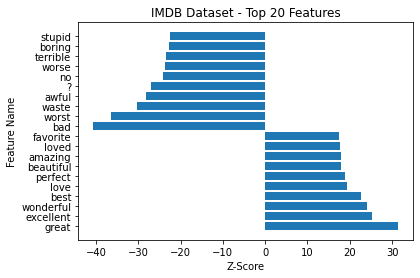

In [ ]:
# Associate each z-score with its feature.
z_scores_with_index = []
for i in range(len(z_scores)):
  z_scores_with_index.append([z_scores[i], to_keep[i]])

# Extract the 10 features with the highest z-score and the 10 features with the lowest z-score
z_scores_with_index.sort()
worst10 = z_scores_with_index[:10]
z_scores_with_index.reverse()
best10 = z_scores_with_index[:10]
top_features = best10 + worst10

# Get the features names. 
feature_names = pd.read_csv("aclImdb/imdb.vocab", header=None)
top_feature_names = []
top_feature_z_scores = []
for feature in top_features:
  top_feature_names.append(feature_names[0][feature[1]])
  top_feature_z_scores.append(feature[0])

# Plot a horizontal bar graph of the top 20 features. 
plt.barh(top_feature_names, top_feature_z_scores)
plt.title("IMDB Dataset - Top 20 Features")
plt.xlabel("Z-Score")
plt.ylabel("Feature Name")
plt.show()

## Evaluate Logistic Regression on the IMDB Dataset

Testing accuracy achieved: 0.81352


<Figure size 432x288 with 0 Axes>

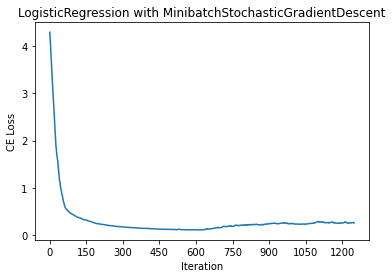

In [ ]:
# Train the Logistic Regression model and evaluate the testing accuracy. 
lr = lr = LogisticRegression(
    gradient_descent=MinibatchStochasticGradientDescent(
        batch_size=20,
        momentum=0.1,
        ),
    learning_rate=0.1,
)
lr = lr.fit(imdb_train_X_final, imdb_train_y_final)
y_test_pred = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, list(lr.predict(imdb_test_X_final)))))
test_accuracy = np.sum(y_test_pred == imdb_test_y_final)/imdb_test_y_final.shape[0]
print("Testing accuracy achieved: " + str(test_accuracy))

# Check the gradient
lr.plot_loss()

## Compare Logistic Regression with KNN

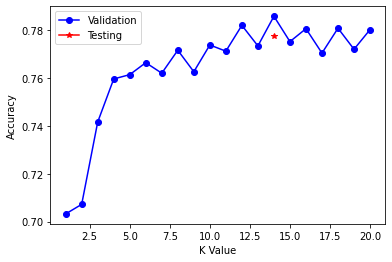

Testing accuracy achieved: 0.77768 with a k-value of 14


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Split the training set into training and validation sets.
imdb_X_train, imdb_X_valid, imdb_y_train, imdb_y_valid = train_test_split(imdb_train_X_final, imdb_train_y_final, test_size = 0.2, random_state=1, shuffle=True)

# Determine the best value of k for this dataset. 
max_k = 20
k_values = []
validation_accuracies = []
for k in range (1, max_k + 1):
  knn = KNeighborsClassifier(n_neighbors = k).fit(imdb_X_train, imdb_y_train)
  imdb_valid_y_pred = knn.predict(imdb_X_valid) 
  imdb_valid_y_pred = (imdb_valid_y_pred > 0.5).astype(int)
  acc_valid = sum(imdb_valid_y_pred == imdb_y_valid)/len(imdb_y_valid)
  k_values.append(k)
  validation_accuracies.append(acc_valid)

# Use the best k value on the test data. 
best_k = k_values[validation_accuracies.index(max(validation_accuracies))]
knn = KNeighborsClassifier(n_neighbors = best_k).fit(imdb_X_train, imdb_y_train)
y_test_pred = knn.predict(imdb_test_X_final)
test_accuracy = np.sum(y_test_pred == imdb_test_y_final)/imdb_test_y_final.shape[0]

# Plot the results
plt.clf()
plt.plot(k_values, validation_accuracies, marker='o', color='blue', label='Validation')
plt.plot(best_k, test_accuracy, marker='*', color='red', label='Testing')
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

print("Testing accuracy achieved: " + str(test_accuracy) + " with a k-value of 14")

## Plot ROC curve and calculate AUROC

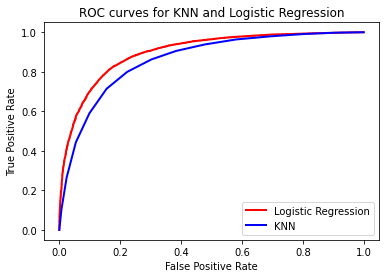

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the probability predictions for LogisticRegression
lr = LogisticRegression(
    gradient_descent=MinibatchStochasticGradientDescent(
        batch_size=20,
        momentum=0.1,
        ),
    learning_rate=0.1,
)
lr = lr.fit(imdb_train_X_final, imdb_train_y_final)
y_test_pred_lr = lr.predict(imdb_test_X_final)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(imdb_test_y_final, y_test_pred_lr)

# Get the probability predictions for KNN. 
knn = KNeighborsClassifier(n_neighbors = 14).fit(imdb_train_X_final, imdb_train_y_final)
y_test_pred_knn = knn.predict_proba(imdb_test_X_final)[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(imdb_test_y_final, y_test_pred_knn)

# Plot ROC curves for KNN and LogisticRegression
plt.clf()
plt.plot(fpr_lr, tpr_lr, "red", lw=2, label="Logistic Regression")
plt.plot(fpr_knn, tpr_knn, "blue", lw=2, label="KNN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for KNN and Logistic Regression')
plt.legend(loc="best")
plt.show()

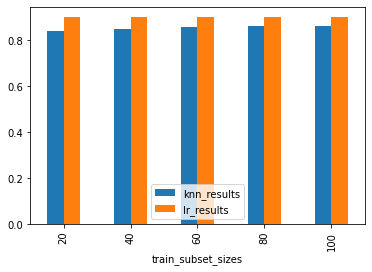

In [ ]:
# Evaluate the AUROC using 20%, 40%, 60%, 80%, 100% of the training data with Logistic Regression and KNN
training_percentages = [20, 40, 60, 80, 100]
aurocs_lr = []
aurocs_knn = []
for percentage in training_percentages:
  if percentage == 100:
    X_train = imdb_train_X_final
    y_train = imdb_train_y_final
  else:
    X_train, _, y_train, _ = train_test_split(imdb_train_X_final, imdb_train_y_final, test_size = 1 - (percentage / 100), random_state=1, shuffle=True)

  lr = LogisticRegression(
    gradient_descent=MinibatchStochasticGradientDescent(
        batch_size=20,
        momentum=0.1,
        ),
    learning_rate=0.1,
  )
  lr = lr.fit(imdb_train_X_final, imdb_train_y_final)
  y_test_pred_lr = lr.predict(imdb_test_X_final)
  auroc_lr = roc_auc_score(imdb_test_y_final, y_test_pred_lr)
  aurocs_lr.append(auroc_lr)

  knn = KNeighborsClassifier(n_neighbors = 14).fit(X_train, y_train)
  y_test_pred_knn = knn.predict_proba(imdb_test_X_final)[:,1]
  auroc_knn = roc_auc_score(imdb_test_y_final, y_test_pred_knn)
  aurocs_knn.append(auroc_knn)

# Plot the AUROC curves for KNN and LogisticRegression
data = pd.DataFrame( {'train_subset_sizes': training_percentages, 'knn_results': aurocs_knn, 'lr_results': aurocs_lr } )
data.plot.bar(x = "train_subset_sizes")

## Evaluate Multiclass Regression on the 20 News Group Dataset

In [ ]:
"""
------ default params -----
epsilon: float = 1e-8,
gradient_descent: BaseGradientDescent = StochasticGradientDescent(),
learning_rate: float = 0.1,
max_iters: float = 1e4,
n_classes: int = None,
"""
import random
random.seed(2022)

mlr_model = MulticlassRegression(gradient_descent = MinibatchStochasticGradientDescent())
fitted = mlr_model.fit(x = final_x_train_set, y = final_y_train_set)
result = mlr_model.predict(final_x_test_set)

<Figure size 432x288 with 0 Axes>

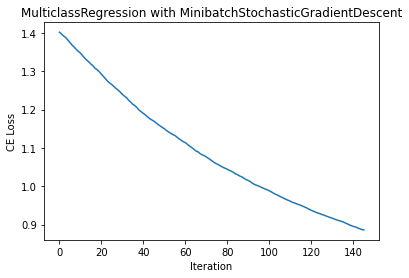

In [ ]:
#Model convergence early on within 200 iterations
mlr_model.plot_loss()

### Compute Classification Accuracy

In [ ]:
#Test set accuracy of ~77%
mlr_model.evaluate_accuracy(result, final_y_test_set)

0.7706598334401025

## Heatmap of largest weights of each Category

In [ ]:
all_weights = mlr_model.weights

def get_top_5_weights_index(category):
  top_category_weights = [x[category] for x in all_weights]
  ind = np.argpartition(top_category_weights, -5)[-5:]
  return ind

#Get the top 5 weights for each category by index before combining into a single list
top_category_0_index = get_top_5_weights_index(0)
top_category_1_index = get_top_5_weights_index(1)
top_category_2_index = get_top_5_weights_index(2)
top_category_3_index = get_top_5_weights_index(3)
all_top_index  =  np.append(top_category_0_index, [top_category_1_index, top_category_2_index, top_category_3_index])

#no duplicates in top weighted featured words for each category
len(np.unique(all_top_index))

20

In [ ]:
def get_top_weights(category):
  top_words_weight = []
  for each in all_top_index:
    top_words_weight.append(all_weights[each][category])
  return top_words_weight

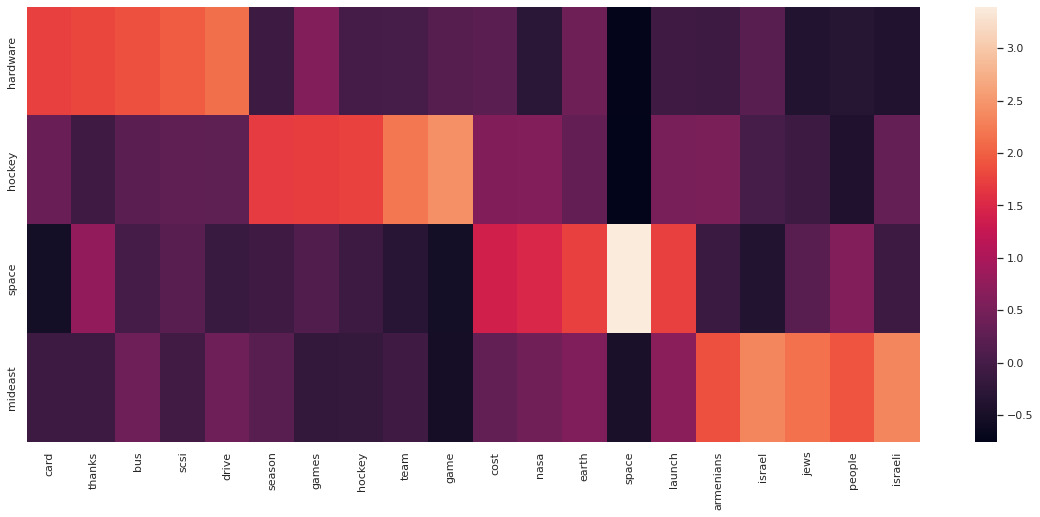

In [ ]:
#categoies were encoded as following, 0: hardware, 1: hockey, 2: space, 3: mideast

#Get name of all top_feature_words
names = [x for x in df_test_final.columns[all_top_index]]

#Get the weights for each word for each category
weights_data = {'hardware' : get_top_weights(0), 'hockey': get_top_weights(1), 'space': get_top_weights(2), 'mideast': get_top_weights(3)}

#Convert to DataFrame for plotting
heatmap_data = pd.DataFrame.from_dict(weights_data, orient='index', columns=names)
heatmap_data

#Plotting the heatmap
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
sns.heatmap(heatmap_data, annot = False)

## Compare Multiclass Regression with KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def knn(x_train, y_train, x_test, y_test):
  # Split the training set into training and validation sets.
  news_X_train, news_X_valid, news_y_train, news_y_valid = train_test_split(x_train, y_train, test_size = 0.3, random_state=2022, shuffle=True)

  # Determine the best value of k for this dataset. 
  max_k = 50
  k_values = []
  validation_accuracies = []
  for k in range (1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors = k).fit(news_X_train, news_y_train)
    news_valid_y_pred = knn.predict(news_X_valid) 
    acc_valid = sum(news_valid_y_pred == news_y_valid)/len(news_y_valid)
    k_values.append(k)
    validation_accuracies.append(acc_valid)


  # Use the best k value on the test data. 
  best_k = k_values[validation_accuracies.index(max(validation_accuracies))]
  knn = KNeighborsClassifier(n_neighbors = best_k).fit(news_X_train, news_y_train)
  y_test_pred = knn.predict(x_test)
  test_accuracy = sum(y_test_pred == y_test)/len(y_test)

  # Plot the results
  plt.clf()
  plt.plot(k_values, validation_accuracies, marker='o', color='blue', label='Validation')
  plt.plot(best_k, test_accuracy, marker='*', color='red', label='Testing')
  plt.xlabel("K Value")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print(f"Best Validation Accuracy achieved: {validation_accuracies[best_k-1]} and Testing accuracy achieved: {test_accuracy} with a k-value of {best_k}")

  return test_accuracy

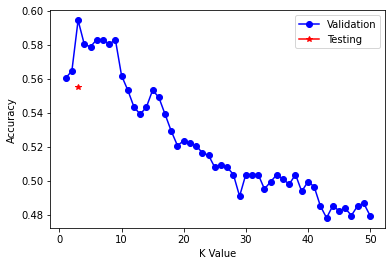

Best Validation Accuracy achieved: 0.5943262411347517 and Testing accuracy achieved: 0.5547725816784113 with a k-value of 3


0.5547725816784113

In [ ]:
knn(final_x_train_set, news_train_y, final_x_test_set, news_test_y)

### Compare the accuracy of the two models as a function of the size of dataset

In [ ]:
def compare_accuracy_two_models(x_train: np.ndarray,
                        x_test: np.ndarray,
                        y_train: np.ndarray,
                        y_test: np.ndarray,
                        train_subset_size: int
                        ):
  
  #train test split at different sizes
  if train_subset_size<1:
    x_train_subset, unused_x_train, y_train_subset, unused_y_valid = train_test_split(x_train, y_train, test_size = (1-train_subset_size), random_state=2022, shuffle=True)
  else:
    x_train_subset = x_train
    y_train_subset = y_train
  #knn model (with previous best_k)
  knn_result = knn(x_train_subset, y_train_subset, x_test, y_test)

  #one hot encode y for training mlr
  df_train_y = pd.DataFrame(y_train_subset).rename(columns = {0:'Category'})
  df_y_train_encoded = pd.get_dummies(df_train_y.Category, prefix='Category').to_numpy()

  #mlr result
  model = MulticlassRegression(gradient_descent = MinibatchStochasticGradientDescent())
  fitted = model.fit(x = x_train_subset, y = df_y_train_encoded)
  result = model.predict(x_test)
  mlr_result = model.evaluate_accuracy(result, final_y_test_set)

  return knn_result, mlr_result

In [ ]:
train_subset_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
knn_results = []
mlr_results = []

for each in train_subset_sizes:
  knn_result, mlr_result = compare_accuracy_two_models(final_x_train_set, final_x_test_set, news_train_y, news_test_y, each)
  knn_results.append(knn_result)
  mlr_results.append(mlr_result)


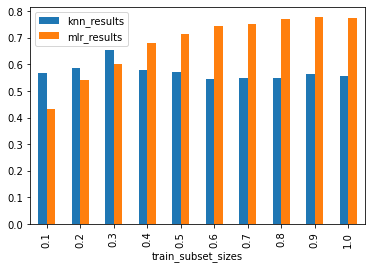

In [ ]:
#KNN performs better at low training sizes, but when trainining set sizes increase, it starts to outperform knn
data = pd.DataFrame( {'train_subset_sizes': train_subset_sizes, 'knn_results': knn_results, 'mlr_results': mlr_results } )
data.plot.bar(x = "train_subset_sizes")

## Extra Experiments

In [ ]:
def extra_experiment_lr(x_train: np.ndarray,
                        x_test: np.ndarray,
                        y_train: np.ndarray,
                        y_test: np.ndarray
                        ) -> list[list[str, float]]:
    """
    Function that will test various permutations of hyperparameters for LogisticRegresision
    """
    results = []
    for learning_rate in [0.001, 0.01, 0.1]:
        for momentum in [0.0, 0.1]:
            sgd_model = LogisticRegression(
                gradient_descent=StochasticGradientDescent(
                    momentum=momentum
                ),
                learning_rate=learning_rate
            )
            sgd_y_pred = np.array(list(map(
                lambda x: 1 if x >= 0.5 else 0,
                list(sgd_model.fit(x_train, y_train).predict(x_test))
            )))
            sgd_model_acc = round(LogisticRegression.evaluate_accuracy(sgd_y_pred, y_test), 2)
            sgd_model_name = f'Logistic, gd: SGD, lr: {learning_rate}, m: {momentum}'
            results.append([sgd_model_name, sgd_model_acc])

            for batch_size in [100, 1000]:
                for shuffle in [False]:
                    mbsgd_model = LogisticRegression(
                        gradient_descent=MinibatchStochasticGradientDescent(
                            batch_size=batch_size,
                            momentum=momentum,
                            shuffle=shuffle
                        ),
                        learning_rate=learning_rate
                        )
                    mbsgd_y_pred = np.array(list(map(
                        lambda x: 1 if x >= 0.5 else 0,
                        list(mbsgd_model.fit(x_train, y_train).predict(x_test))
                    )))
                    mbsgd_model_acc = round(LogisticRegression.evaluate_accuracy(mbsgd_y_pred, y_test), 2)
                    mbsgd_model_name = f'Logistic, gd: MbSGD, lr: {learning_rate}, m: {momentum}, batch: {batch_size}, s: {shuffle}'
                    results.append([mbsgd_model_name, mbsgd_model_acc])
    
    return sorted(results, key=lambda x: x[1], reverse=True)

In [ ]:
lr_results = extra_experiment_lr(imdb_train_X_final, imdb_test_X_final, imdb_train_y_final, imdb_test_y_final)
for i in lr_results:
  print(i)

['Logistic, gd: MbSGD, lr: 0.1, m: 0.0, batch: 100, s: False', 0.81]
['Logistic, gd: MbSGD, lr: 0.1, m: 0.1, batch: 100, s: False', 0.81]
['Logistic, gd: MbSGD, lr: 0.1, m: 0.0, batch: 1000, s: False', 0.53]
['Logistic, gd: MbSGD, lr: 0.01, m: 0.0, batch: 100, s: False', 0.51]
['Logistic, gd: MbSGD, lr: 0.01, m: 0.1, batch: 100, s: False', 0.5]
['Logistic, gd: SGD, lr: 0.1, m: 0.1', 0.5]
['Logistic, gd: MbSGD, lr: 0.1, m: 0.1, batch: 1000, s: False', 0.5]
['Logistic, gd: SGD, lr: 0.1, m: 0.0', 0.47]
['Logistic, gd: MbSGD, lr: 0.001, m: 0.1, batch: 100, s: False', 0.46]
['Logistic, gd: SGD, lr: 0.01, m: 0.0', 0.46]
['Logistic, gd: SGD, lr: 0.001, m: 0.0', 0.45]
['Logistic, gd: MbSGD, lr: 0.001, m: 0.0, batch: 100, s: False', 0.45]
['Logistic, gd: SGD, lr: 0.001, m: 0.1', 0.45]
['Logistic, gd: MbSGD, lr: 0.01, m: 0.0, batch: 1000, s: False', 0.45]
['Logistic, gd: MbSGD, lr: 0.01, m: 0.1, batch: 1000, s: False', 0.45]
['Logistic, gd: MbSGD, lr: 0.001, m: 0.0, batch: 1000, s: False', 0.44]

In [ ]:
def extra_experiment_mcr(x_train: np.ndarray,
                         x_test: np.ndarray,
                         y_train: np.ndarray,
                         y_test: np.ndarray
                         ) -> list[list[str, float]]:
    """
    Function that will test various permutations of hyperparameters for MulticlassRegresision
    """
    results = []
    for learning_rate in [0.001, 0.01, 0.1]:
        for momentum in [0.0, 0.1]:
            sgd_model = MulticlassRegression(
                gradient_descent=StochasticGradientDescent(
                    momentum=momentum
                ),
                learning_rate=learning_rate
            )
            sgd_y_pred = sgd_model.fit(x_train, y_train).predict(x_test)
            sgd_model_acc = round(MulticlassRegression.evaluate_accuracy(sgd_y_pred, y_test), 2)
            sgd_model_name = f'Multiclass, gd: SGD, lr: {learning_rate}, m: {momentum}'
            results.append([sgd_model_name, sgd_model_acc])

            for batch_size in [100, 1000]:
                for shuffle in [False]:
                    mbsgd_model = MulticlassRegression(
                        gradient_descent=MinibatchStochasticGradientDescent(
                            batch_size=batch_size,
                            momentum=momentum,
                            shuffle=shuffle
                        ),
                        learning_rate=learning_rate
                    )
                    mbsgd_y_pred = mbsgd_model.fit(x_train, y_train).predict(x_test)
                    mbsgd_model_acc = round(MulticlassRegression.evaluate_accuracy(mbsgd_y_pred, y_test), 2)
                    mbsgd_model_name = f'Multiclass, gd: MbSGD, lr: {learning_rate}, m: {momentum}, batch: {batch_size}, s: {shuffle}'
                    results.append([mbsgd_model_name, mbsgd_model_acc])

    return sorted(results, key=lambda x: x[1], reverse=True)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer().fit(news_train_y)
lb_news_train_y = lb.transform(news_train_y)
lb_news_test_y = lb.transform(news_test_y)
mcr_results = extra_experiment_mcr(final_x_train_set, final_x_test_set, lb_news_train_y, lb_news_test_y)
for i in mcr_results:
  print(i)

['Multiclass, gd: MbSGD, lr: 0.1, m: 0.1, batch: 1000, s: False', 0.78]
['Multiclass, gd: MbSGD, lr: 0.1, m: 0.0, batch: 100, s: False', 0.77]
['Multiclass, gd: MbSGD, lr: 0.1, m: 0.0, batch: 1000, s: False', 0.77]
['Multiclass, gd: MbSGD, lr: 0.1, m: 0.1, batch: 100, s: False', 0.77]
['Multiclass, gd: MbSGD, lr: 0.01, m: 0.1, batch: 100, s: False', 0.4]
['Multiclass, gd: MbSGD, lr: 0.01, m: 0.0, batch: 1000, s: False', 0.37]
['Multiclass, gd: MbSGD, lr: 0.01, m: 0.0, batch: 100, s: False', 0.35]
['Multiclass, gd: MbSGD, lr: 0.01, m: 0.1, batch: 1000, s: False', 0.35]
['Multiclass, gd: SGD, lr: 0.1, m: 0.1', 0.32]
['Multiclass, gd: MbSGD, lr: 0.001, m: 0.1, batch: 100, s: False', 0.27]
['Multiclass, gd: SGD, lr: 0.001, m: 0.1', 0.26]
['Multiclass, gd: SGD, lr: 0.01, m: 0.0', 0.26]
['Multiclass, gd: MbSGD, lr: 0.001, m: 0.0, batch: 100, s: False', 0.24]
['Multiclass, gd: MbSGD, lr: 0.001, m: 0.0, batch: 1000, s: False', 0.24]
['Multiclass, gd: MbSGD, lr: 0.001, m: 0.1, batch: 1000, s: F